<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 4*

# 📝 Assignment
---

# 🌱 **기본 과제**

캐글 대회를 이어서 진행합니다. 

In [ ]:
!pip install category_encoders
!pip install hyperopt

## **Part 1. EDA 및 Feature Engineering**

캐글 inclass competition 마지막 날입니다. 더 진행한 EDA와 Feature Engineering이 있다면 진행해주세요!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [ ]:
# 데이터셋 불러오기 - H1N1 백신 관련 데이터

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [ ]:
# train을 features & target으로 나눈다.
y_train = train[target]
X_train = train.drop(target, axis=1)

# 데이터셋 크기 확인 (train의 features, train의 target의 row 수가 일치해야 한다.)
X_train.shape, y_train.shape

((42154, 38), (42154,))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42154 entries, 0 to 42153
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 33734 non-null  float64
 1   h1n1_knowledge               33734 non-null  float64
 2   behavioral_antiviral_meds    33635 non-null  float64
 3   behavioral_avoidance         33482 non-null  float64
 4   behavioral_face_mask         33710 non-null  float64
 5   behavioral_wash_hands        33683 non-null  float64
 6   behavioral_large_gatherings  33640 non-null  float64
 7   behavioral_outside_home      33633 non-null  float64
 8   behavioral_touch_face        33571 non-null  float64
 9   doctor_recc_h1n1             40269 non-null  float64
 10  doctor_recc_seasonal         40269 non-null  float64
 11  chronic_med_condition        40837 non-null  float64
 12  child_under_6_months         32705 non-null  float64
 13  health_insurance

0    0.760948
1    0.239052
Name: vacc_h1n1_f, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


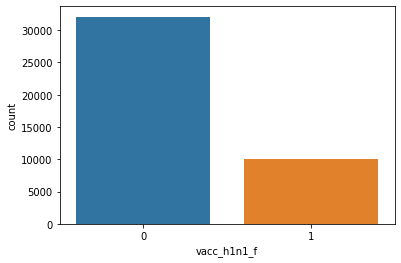

In [ ]:
# 타겟 비율 확인
sns.countplot(train[target])
print(train[target].value_counts(normalize=True))

In [ ]:
# Feature Engineering을 수행합니다.
def engineer(df):
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if "behavioral" in col]
    df["behaviorals"] = df[behaviorals].sum(axis=1)

    # 사용하지 않는 특성을 drop합니다.
    dels = [col for col in df.columns if ("employment" in col or "sess" in col)]
    df.drop(columns=dels, inplace=True)
    df.drop(columns='state', inplace=True)

    return df


train = engineer(train.copy())
test = engineer(test.copy())

# feature과 label을 분리합니다.
X_train, y_train = train.drop(columns=target), train[target]
X_test = test

In [ ]:
X_train.describe(include='object')

,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,census_msa
count,33375,33329,33285,33220,33153,33089,42154,42154
unique,6,6,6,6,6,6,7,3
top,Somewhat Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Somewhat Low,Not At All Worried,65+ Years,"MSA, Not Principle City"
freq,14729,12520,11582,14543,11397,14749,8517,18957


## **Part 2. Hyperparameter Tuning**

### **2-1. 모델 학습**
- Randomforest 혹은 XGBoost를 학습시키세요.
- 분류문제에 맞는 scoring parameter metric을 사용하세요.
- OrdinalEncoder 혹은 TargetEncoder 사용을 권합니다.
- RandomizedSearchCV 를 사용해서 하이퍼파라미터 튜닝을 진행하고 최고 성능을 보이는 모델로 예측을 진행한 후 캐글에 제출합니다.

In [ ]:
neg, pos = train[target].value_counts()
weight = neg/pos

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , scale_pos_weight = weight
                 )
)


In [ ]:
from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV

params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
    "xgbclassifier__learning_rate" : [0.05, 0.1, 0.3]
}


randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="f1",
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
)

randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=2;, score=0.569 total time=  23.7s
[CV 2/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=2;, score=0.572 total time=   9.2s
[CV 3/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=2;, score=0.561 total time=   9.3s
[CV 1/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.5780093202212182, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.575 total time=   7.2s
[CV 2/3] END simpleimputer__strateg

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('xgbclassifier',
                                              XGBClassifier(n_estimators=200,
                                                            n_jobs=-1,
                                                            random_state=2,
                                                            scale_pos_weight=3.183189441301975))]),
                   param_distributions={'simpleimputer__strategy': ['median',
                                                                    'mean'],
                                        'xgbclassifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb965264bd0>,
                                        'xgbclassifier__learning_rate': [0.

In [ ]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 f1: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'xgbclassifier__colsample_bytree': 0.8609993861334124, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 4}
최적 f1:  0.6204891468395445


### **2-2. 결과 제출**
- 테스트 세트에 대한 예측 결과를 캐글에 제출하세요. 

##### **Q. 캐글 Leaderboard의 개선된 본인의 score를 제출해 주세요.**

In [ ]:
# csv 파일 저장을 위한 구글 드라이브 마운트
import sys

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final = randomized_search.best_estimator_
y_pred_test = final.predict(X_test)

sample_submission[target] = y_pred_test
sample_submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,1
28100,28100,0
28101,28101,0
28102,28102,1


In [ ]:
# 개수 확인 (예측값에서 0, 1 개수 확인)
(y_pred_test == 0).sum(), (y_pred_test == 1).sum()

(18474, 9630)

In [ ]:
# 개수 확인 (제출폼 데이터프레임에서 0, 1 개수 확인)
sample_submission[target].value_counts()

0    18474
1     9630
Name: vacc_h1n1_f, dtype: int64

In [ ]:
# 저장
sample_submission.to_csv("submission_final.csv", index = False)

# 🥇 **도전 과제**

- `hyperopt` 라이브러리를 사용하여 Bayesian Search를 진행해보세요.
- Randomized Search와 비교해보세요. 
    - 최적의 하이퍼파라미터 값은 어떻게 다른가요?
    - 최적의 f1 score는 어떻게 다른가요?